# Soil Tutorial

## Introduction

This notebook is an introduction to the soil agent-based social network simulation framework.
In particular, we will focus on a specific use case: studying the propagation of news in a social network.

The steps we will follow are:

* Modelling the behavior of agents
* Running the simulation using different configurations
* Analysing the results of each simulation

But before that, let's import the soil module and networkx.

In [1]:
import soil
import networkx as nx
 
%load_ext autoreload
%autoreload 2

%pylab inline
# To display plots in the notebooed_

Populating the interactive namespace from numpy and matplotlib


## Basic concepts

There are three main elements in a soil simulation:
    
* The network topology. A simulation may use an existing NetworkX topology, or generate one on the fly
* Agents. There are two types: 1) network agents, which are linked to a node in the topology, and 2) environment agents, which are freely assigned to the environment.
* The environment. It assigns agents to nodes in the network, and stores the environment parameters (shared state for all agents).

Soil is based on ``simpy``, which is an event-based network simulation library.
Soil provides several abstractions over events to make developing agents easier.
This means you can use events (timeouts, delays) in soil, but for the most part we will assume your models will be step-based.


## Modeling behaviour

Our first step will be to model how every person in the social network reacts when it comes to news.
We will follow a very simple model (a finite state machine).

There are two types of people, those who have heard about a newsworthy event (infected) or those who have not (neutral).
A neutral person may heard about the news either on the TV (with probability **prob_tv_spread**) or through their friends.
Once a person has heard the news, they will spread it to their friends (with a probability **prob_neighbor_spread**).
Some users do not have a TV, so they only rely on their friends.

The spreading probabilities will change over time due to different factors.
We will represent this variance using an environment agent.

### Network Agents

A basic network agent in Soil should inherit from ``soil.agents.BaseAgent``, and define its behaviour in every step of the simulation by implementing a ``run(self)`` method.
The most important attributes of the agent are:

* ``agent.state``, a dictionary with the state of the agent. ``agent.state['id']`` reflects the state id of the agent. That state id can be used to look for other networks in that specific state. The state can be access via the agent as well. For instance:
```py
a = soil.agents.BaseAgent(env=env)
a['hours_of_sleep'] = 10
print(a['hours_of_sleep'])
```
  The state of the agent is stored in every step of the simulation:
  ```py
  print(a['hours_of_sleep', 10]) # hours of sleep before step #10
  print(a[None, 0]) # whole state of the agent before step #0
  ```

* ``agent.env``, a reference to the environment. Most commonly used to get access to the environment parameters and the topology:
    ```py
    a.env.G.nodes() # Get all nodes ids in the topology
    a.env['minimum_hours_of_sleep']

    ```

Since our model is a finite state machine, we will be basing it on ``soil.agents.FSM``.

With ``soil.agents.FSM``, we do not need to specify a ``step`` method.
Instead, we describe every step as a function.
To change to another state, a function may return the new state.
If no state is returned, the state remains unchanged.[
It will consist of two states, ``neutral`` (default) and ``infected``.

Here's the code:

In [2]:
import random

class NewsSpread(soil.agents.FSM):
    @soil.agents.default_state
    @soil.agents.state
    def neutral(self):
        r = random.random()
        if self['has_tv'] and r < self.env['prob_tv_spread']:
                return self.infected
        return
    
    @soil.agents.state
    def infected(self):
        prob_infect = self.env['prob_neighbor_spread']
        for neighbor in self.get_neighboring_agents(state_id=self.neutral.id):
            r = random.random()
            if r < prob_infect:
                neighbor.state['id'] = self.infected.id
        return
        

### Environment agents

Environment agents allow us to control the state of the environment.
In this case, we will use an environment agent to simulate a very viral event.

When the event happens, the agent will modify the probability of spreading the rumor.

In [3]:
NEIGHBOR_FACTOR = 0.9
TV_FACTOR = 0.5
class NewsEnvironmentAgent(soil.agents.BaseAgent):
    def step(self):
        if self.now == self['event_time']:
            self.env['prob_tv_spread'] = 1
            self.env['prob_neighbor_spread'] = 1
        elif self.now > self['event_time']:
            self.env['prob_tv_spread'] = self.env['prob_tv_spread'] * TV_FACTOR
            self.env['prob_neighbor_spread'] = self.env['prob_neighbor_spread'] * NEIGHBOR_FACTOR

### Testing the agents

Feel free to skip this section if this is your first time with soil.

Testing agents is not easy, and this is not a thorough testing process for agents.
Rather, this section is aimed to show you how to access internal pats of soil so you can test your agents.

First of all, let's check if our network agent has the states we would expect:

In [4]:
NewsSpread.states

{'infected': <function __main__.NewsSpread.infected>,
 'neutral': <function __main__.NewsSpread.neutral>}

Now, let's run a simulation on a simple network. It is comprised of three nodes:


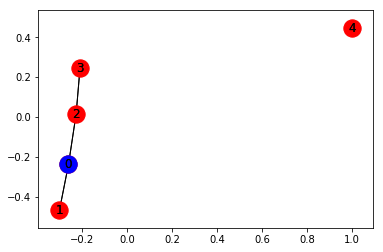

In [5]:
G = nx.Graph()
G.add_edge(0, 1)
G.add_edge(0, 2)
G.add_edge(2, 3)
G.add_node(4)
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, node_color='red')
nx.draw_networkx(G, pos, nodelist=[0], node_color='blue')

Let's run a simple simulation that assigns a NewsSpread agent to all the nodes in that network.
Notice how node 0 is the only one with a TV.

In [6]:
env_params = {'prob_tv_spread': 0,
             'prob_neighbor_spread': 0}

MAX_TIME = 100
EVENT_TIME = 10

sim = soil.simulation.SoilSimulation(topology=G,
                                     num_trials=1,
                                     max_time=MAX_TIME,
                                     environment_agents=[{'agent_type': NewsEnvironmentAgent,
                                                         'state': {
                                                             'event_time': EVENT_TIME
                                                         }}],
                                     network_agents=[{'agent_type': NewsSpread,
                                                      'weight': 1}],
                                     states={0: {'has_tv': True}},
                                     default_state={'has_tv': False},
                                     environment_params=env_params)
env = sim.run_simulation()[0]

INFO:soil.utils:Trial: 0
INFO:soil.utils:	Running
INFO:soil.utils:Finished trial in 0.02695441246032715 seconds
INFO:soil.utils:NOT dumping results
INFO:soil.utils:Finished simulation in 0.03360605239868164 seconds


Now we can access the results of the simulation and compare them to our expected results

In [7]:
agents = list(env.network_agents)

# Until the event, all agents are neutral
for t in range(10):
    for a in agents:
        assert a['id', t] == a.neutral.id

# After the event, the node with a TV is infected, the rest are not
assert agents[0]['id', 11] == NewsSpread.infected.id

for a in agents[1:4]:
    assert a['id', 11] == NewsSpread.neutral.id

# At the end, the agents connected to the infected one will probably be infected, too.
assert agents[1]['id', MAX_TIME] == NewsSpread.infected.id
assert agents[2]['id', MAX_TIME] == NewsSpread.infected.id

# But the node with no friends should not be affected
assert agents[4]['id', MAX_TIME] == NewsSpread.neutral.id
        

Lastly, let's see if the probabilities have decreased as expected:

In [8]:
assert abs(env.environment_params['prob_neighbor_spread'] - (NEIGHBOR_FACTOR**(MAX_TIME-1-10))) < 10e-4
assert abs(env.environment_params['prob_tv_spread'] - (TV_FACTOR**(MAX_TIME-1-10))) < 10e-6

## Running the simulation

To run a simulation, we need a configuration.
Soil can load configurations from python dictionaries as well as JSON and YAML files.
For this demo, we will use a python dictionary:

In [9]:
config = {
    'name': 'ExampleSimulation',
    'max_time': 20,
    'interval': 1,
    'num_trials': 1,
    'network_params': {
       'generator': 'complete_graph',
        'n': 500,
    },
    'network_agents': [
        {
            'agent_type': NewsSpread,
            'weight': 1,
            'state': {
                'has_tv': False
            }
        },
        {
            'agent_type': NewsSpread,
            'weight': 2,
            'state': {
                'has_tv': True
            }
        }
    ],
    'environment_agents':[
        {'agent_type': NewsEnvironmentAgent,
         'state': {
             'event_time': 10
         }
        }
    ],
    'states': [ {'has_tv': True} ],
    'environment_params':{
        'prob_tv_spread': 0.01,
        'prob_neighbor_spread': 0.5
    }
}

Let's run our simulation:

In [10]:
soil.simulation.run_from_config(config, dump=False)

INFO:soil.utils:Using config(s): ExampleSimulation
INFO:soil.utils:Dumping results to soil_output/ExampleSimulation : False
INFO:soil.utils:Trial: 0
INFO:soil.utils:	Running
INFO:soil.utils:Finished trial in 5.869051456451416 seconds
INFO:soil.utils:NOT dumping results
INFO:soil.utils:Finished simulation in 6.9609293937683105 seconds


In real life, you probably want to run several simulations, varying some of the parameters so that you can compare and answer your research questions.

For instance:
    
* Does the outcome depend on the structure of our network? We will use different generation algorithms to compare them (Barabasi-Albert and Erdos-Renyi)
* How does neighbor spreading probability affect my simulation? We will try probability values in the range of [0, 0.4], in intervals of 0.1.

In [11]:
network_1 = {
       'generator': 'erdos_renyi_graph',
        'n': 500,
        'p': 0.1
}
network_2 = {
       'generator': 'barabasi_albert_graph',
        'n': 500,
        'm': 2
}


for net in [network_1, network_2]:
    for i in range(5):
        prob = i / 10
        config['environment_params']['prob_neighbor_spread'] = prob
        config['network_params'] = net
        config['name'] = 'Spread_{}_prob_{}'.format(net['generator'], prob)
        s = soil.simulation.run_from_config(config)

INFO:soil.utils:Using config(s): Spread_erdos_renyi_graph_prob_0.0
INFO:soil.utils:Dumping results to soil_output/Spread_erdos_renyi_graph_prob_0.0 : True
INFO:soil.utils:Trial: 0
INFO:soil.utils:	Running
INFO:soil.utils:Finished trial in 1.2258412837982178 seconds
INFO:soil.utils:Dumping results to soil_output/Spread_erdos_renyi_graph_prob_0.0
INFO:soil.utils:Finished simulation in 5.597268104553223 seconds
INFO:soil.utils:Using config(s): Spread_erdos_renyi_graph_prob_0.1
INFO:soil.utils:Dumping results to soil_output/Spread_erdos_renyi_graph_prob_0.1 : True
INFO:soil.utils:Trial: 0
INFO:soil.utils:	Running
INFO:soil.utils:Finished trial in 1.3026399612426758 seconds
INFO:soil.utils:Dumping results to soil_output/Spread_erdos_renyi_graph_prob_0.1
INFO:soil.utils:Finished simulation in 5.534018278121948 seconds
INFO:soil.utils:Using config(s): Spread_erdos_renyi_graph_prob_0.2
INFO:soil.utils:Dumping results to soil_output/Spread_erdos_renyi_graph_prob_0.2 : True
INFO:soil.utils:Trial

The results are conveniently stored in pickle (simulation), csv and sqlite (history of agent and environment state) and gexf (dynamic network) format.

In [12]:
!tree soil_output
!du -xh soil_output/*

soil_output
├── Spread_barabasi_albert_graph_prob_0.0
│   ├── Spread_barabasi_albert_graph_prob_0.0.dumped.yml
│   ├── Spread_barabasi_albert_graph_prob_0.0.simulation.pickle
│   ├── Spread_barabasi_albert_graph_prob_0.0_trial_0.backup1508409808.7944386.sqlite
│   ├── Spread_barabasi_albert_graph_prob_0.0_trial_0.backup1508428617.9811945.sqlite
│   ├── Spread_barabasi_albert_graph_prob_0.0_trial_0.db.sqlite
│   ├── Spread_barabasi_albert_graph_prob_0.0_trial_0.environment.csv
│   └── Spread_barabasi_albert_graph_prob_0.0_trial_0.gexf
├── Spread_barabasi_albert_graph_prob_0.1
│   ├── Spread_barabasi_albert_graph_prob_0.1.dumped.yml
│   ├── Spread_barabasi_albert_graph_prob_0.1.simulation.pickle
│   ├── Spread_barabasi_albert_graph_prob_0.1_trial_0.backup1508409810.9913027.sqlite
│   ├── Spread_barabasi_albert_graph_prob_0.1_trial_0.backup1508428620.3419535.sqlite
│   ├── Spread_barabasi_albert_graph_prob_0.1_trial_0.db.sqlite
│   ├── Spread_barabasi_albert_graph_prob_0.1_trial_0.environ

## Analysing the results

### Loading data

Once the simulations are over, we can use soil to analyse the results.

Soil allows you to load results for specific trials, or for a set of trials if you specify a pattern. The specific methods are:

* `analysis.read_data(<directory pattern>)` to load all the results from a directory. e.g. `read_data('my_simulation/')`. For each trial it finds in each folder matching the pattern, it will return the dumped configuration for the simulation, the results of the trial, and the configuration itself. By default, it will try to load data from the sqlite database. 
* `analysis.read_csv(<csv_file>)` to load all the results from a CSV file. e.g. `read_csv('my_simulation/my_simulation_trial0.environment.csv')`
* `analysis.read_sql(<sqlite_file>)` to load all the results from a sqlite database . e.g. `read_sql('my_simulation/my_simulation_trial0.db.sqlite')`

Let's see it in action by loading the stored results into a pandas dataframe:

In [13]:
from soil.analysis import *

In [14]:
df  = read_csv('soil_output/Spread_barabasi_albert_graph_prob_0.0/Spread_barabasi_albert_graph_prob_0.0_trial_0.environment.csv', keys=['id'])
df

,agent_id,t_step,key,value,value_type
5,0,0,id,neutral,str
7,1,0,id,neutral,str
9,2,0,id,neutral,str
11,3,0,id,neutral,str
13,4,0,id,neutral,str
15,5,0,id,neutral,str
17,6,0,id,neutral,str
19,7,0,id,neutral,str
21,8,0,id,neutral,str
23,9,0,id,neutral,str


Soil can also process the data for us and return a dataframe with as many columns as there are attributes in the environment and the agent states:

In [15]:
env, agents = process(df)
agents

id
t_step agent_id          
0      0          neutral
       1          neutral
       10         neutral
       100        neutral
       101        neutral
       102        neutral
       103        neutral
       104        neutral
       105        neutral
       106        neutral
       107        neutral
       108        neutral
       109        neutral
       11         neutral
       110        neutral
       111        neutral
       112        neutral
       113        neutral
       114        neutral
       115        neutral
       116        neutral
       117        neutral
       118        neutral
       119        neutral
       12         neutral
       120        neutral
       121        neutral
       122        neutral
       123        neutral
       124        neutral
...                   ...
20     72        infected
       73        infected
       74        infected
       75        infected
       76        infected
       77        infected
       78        infected
       79        infected
       8         infected
       80        infected
       81        infected
       82        infected
       83        infected
       84        infected
       85        infected
       86        infected
       87        infected
       88        infected
       89        infected
       9         infected
       90        infected
       91        infected
       92        infected
       93        infected
       94        infected
       95        infected
       96        infected
       97        infected
       98        infected
       99        infected

[10500 rows x 1 columns]

The index of the results are the simulation step and the agent_id. Hence, we can access the state of the simulation at a given step: 

In [16]:
agents.loc[0]

,id
agent_id,
0,neutral
1,neutral
10,neutral
100,neutral
101,neutral
102,neutral
103,neutral
104,neutral
105,neutral


Or, we can perform more complex tasks such as showing the agents that have changed their state between two simulation steps:

In [17]:
changed = agents.loc[1]['id'] != agents.loc[0]['id']
agents.loc[0][changed]

,id
agent_id,
140,neutral
164,neutral
170,neutral
310,neutral
455,neutral


To focus on specific agents, we can swap the levels of the index:

In [18]:
agents1 = agents.swaplevel()

In [19]:
agents1.loc['0'].dropna(axis=1)

,id
t_step,
0,neutral
1,neutral
2,neutral
3,neutral
4,neutral
5,neutral
6,neutral
7,neutral
8,neutral


### Plotting data

If you don't want to work with pandas, you can also use some pre-defined functions from soil to conveniently plot the results:

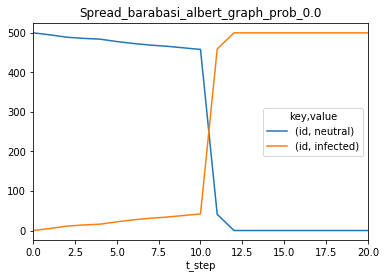

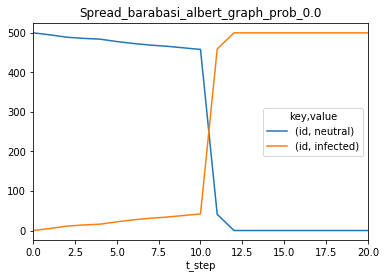

In [20]:
plot_all('soil_output/Spread_barabasi_albert_graph_prob_0.0/', get_count, 'id');

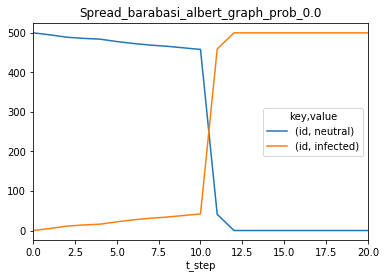

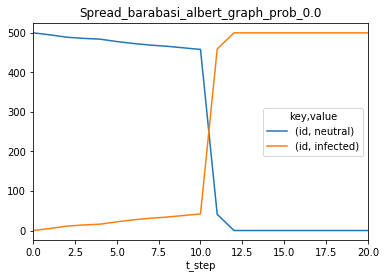

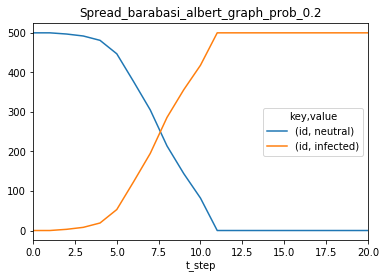

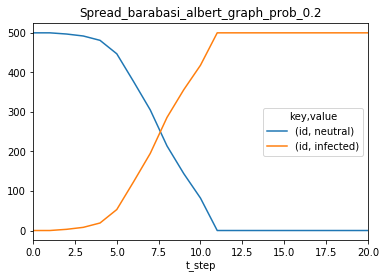

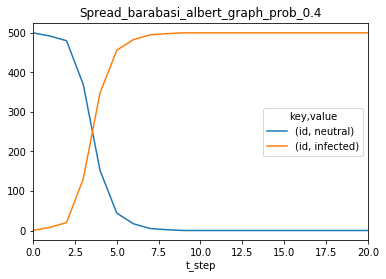

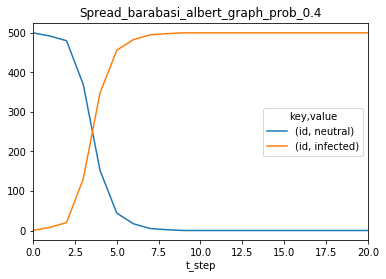

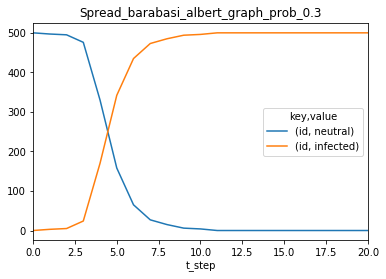

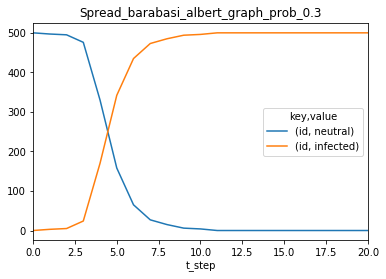

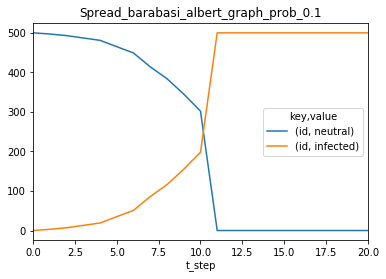

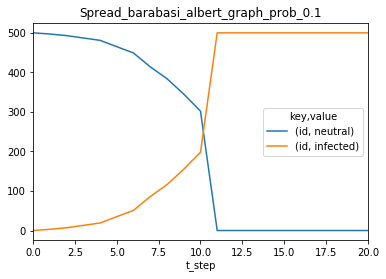

In [21]:
plot_all('soil_output/Spread_barabasi*', get_count, 'id');

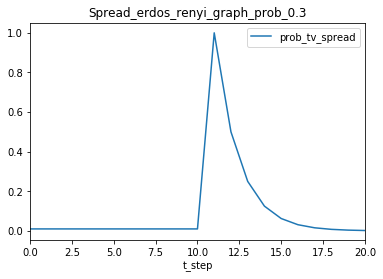

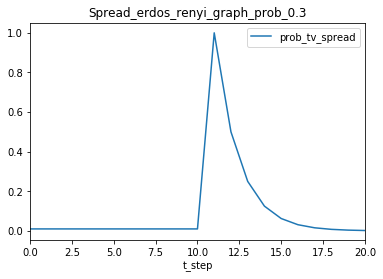

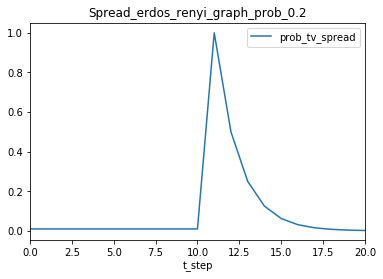

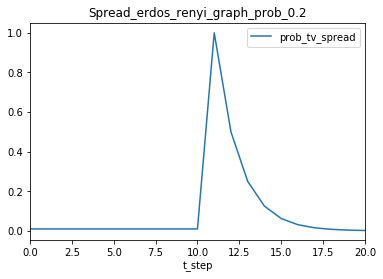

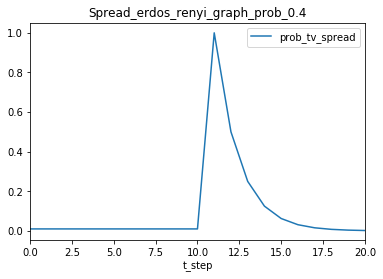

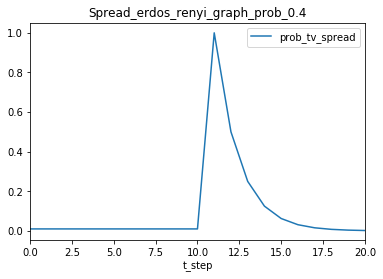

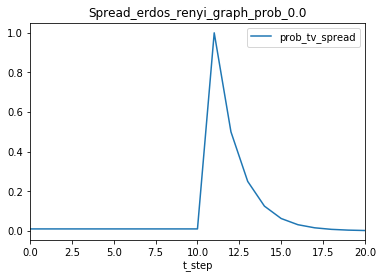

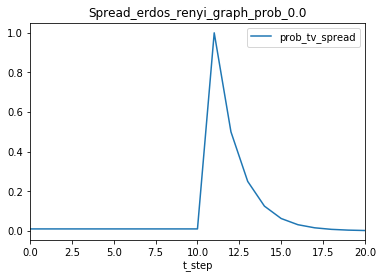

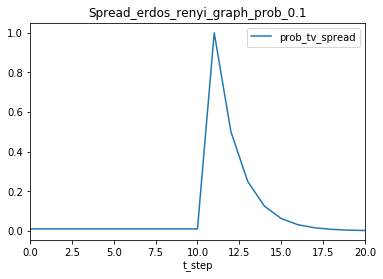

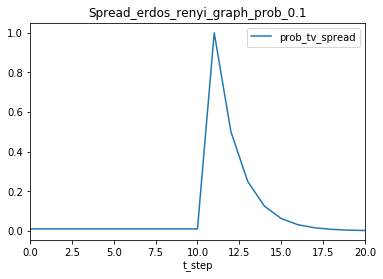

In [22]:
plot_all('soil_output/Spread_erdos*', get_value, 'prob_tv_spread');

### Manually plotting with pandas

Although the simplest way to visualize the results of a simulation is to use the built-in methods in the analysis module, sometimes the setup is more complicated and we need to explore the data a little further.

For that, we can use native pandas over the results.

Soil provides some convenience methods to simplify common operations:

* `analysis.split_df` to separate a history dataframe into environment and agent parameters.
* `analysis.get_count` to get a dataframe with the value counts for different attributes during the simulation.
* `analysis.get_value` to get the evolution of the value of an attribute during the simulation.

And, as we saw earlier, `analysis.process` can turn a dataframe in canonical form into a dataframe with a column per attribute.


In [23]:
p = read_sql('soil_output/Spread_barabasi_albert_graph_prob_0.0/Spread_barabasi_albert_graph_prob_0.0_trial_0.db.sqlite')
env, agents = split_df(p);

Let's look at the evolution of agent parameters in the simulation

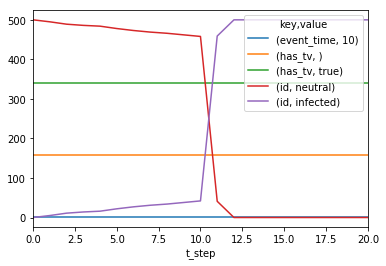

In [24]:
res = agents.groupby(by=['t_step', 'key', 'value']).size().unstack(level=[1,2]).fillna(0)
res.plot();

As we can see, `event_time` is cluttering our results, 

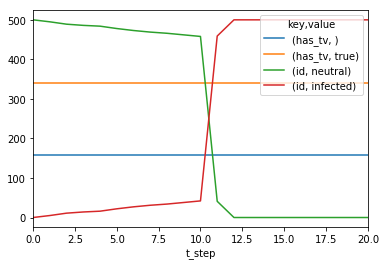

In [25]:
del res['event_time']
res.plot()

In [28]:
processed = process_one(agents);
processed

event_time  has_tv        id
t_step agent_id                                          
0      0                              0    True   neutral
       1                              0   False   neutral
       10                             0    True   neutral
       100                            0    True   neutral
       101                            0    True   neutral
       102                            0   False   neutral
       103                            0    True   neutral
       104                            0    True   neutral
       105                            0   False   neutral
       106                            0   False   neutral
       107                            0    True   neutral
       108                            0    True   neutral
       109                            0   False   neutral
       11                             0    True   neutral
       110                            0   False   neutral
       111                            0   False   neutral
       112                            0    True   neutral
       113                            0    True   neutral
       114                            0    True   neutral
       115                            0    True   neutral
       116                            0   False   neutral
       117                            0    True   neutral
       118                            0    True   neutral
       119                            0   False   neutral
       12                             0   False   neutral
       120                            0   False   neutral
       121                            0    True   neutral
       122                            0    True   neutral
       123                            0    True   neutral
       124                            0   False   neutral
...                                 ...     ...       ...
20     73                             0    True  infected
       74                             0    True  infected
       75                             0    True  infected
       76                             0    True  infected
       77                             0    True  infected
       78                             0    True  infected
       79                             0   False  infected
       8                              0   False  infected
       80                             0    True  infected
       81                             0   False  infected
       82                             0   False  infected
       83                             0    True  infected
       84                             0   False  infected
       85                             0    True  infected
       86                             0    True  infected
       87                             0    True  infected
       88                             0   False  infected
       89                             0   False  infected
       9                              0    True  infected
       90                             0    True  infected
       91                             0    True  infected
       92                             0    True  infected
       93                             0   False  infected
       94                             0    True  infected
       95                             0    True  infected
       96                             0    True  infected
       97                             0    True  infected
       98                             0   False  infected
       99                             0    True  infected
       NewsEnvironmentAgent          10   False         0

[10521 rows x 3 columns]

Which is equivalent to:

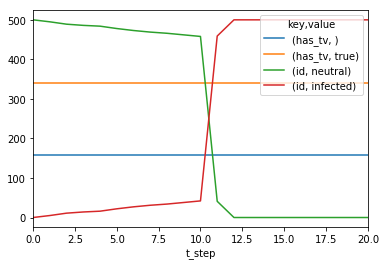

In [30]:
get_count(agents, 'id', 'has_tv').plot()

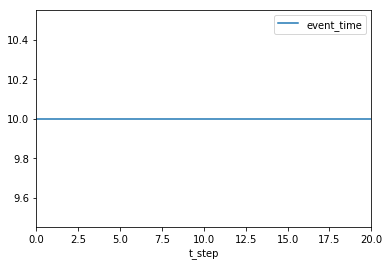

In [31]:
get_value(agents, 'event_time').plot()

## Dealing with bigger data

In [32]:
from soil import analysis

In [33]:
!du -xsh ../rabbits/soil_output/rabbits_example/

267M	../rabbits/soil_output/rabbits_example/


If we tried to load the entire history, we would probably run out of memory. Hence, it is recommended that you also specify the attributes you are interested in.

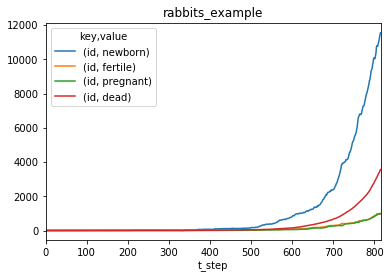

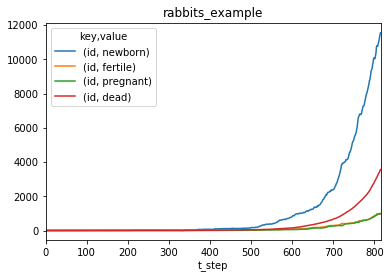

In [34]:
p = analysis.plot_all('../rabbits/soil_output/rabbits_example/', analysis.get_count, 'id')

In [39]:
df = analysis.read_sql('../rabbits/soil_output/rabbits_example/rabbits_example_trial_0.db.sqlite', keys=['id', 'rabbits_alive'])

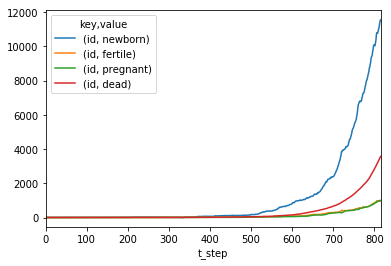

In [40]:
states = analysis.get_count(df, 'id')
states.plot()

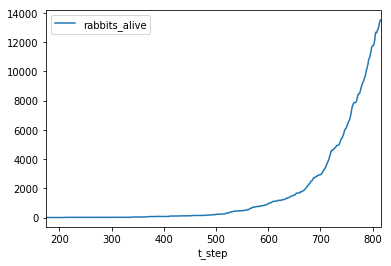

In [41]:
alive = analysis.get_value(df, 'rabbits_alive', 'rabbits_alive', aggfunc='sum').apply(pd.to_numeric)
alive.plot()

/home/jfernando/.local/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


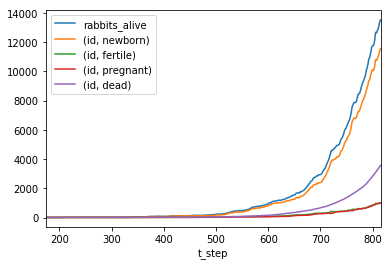

In [44]:
h = alive.join(states);
h.plot();

In [ ]:
states[[('id','newborn'),('id','fertile'),('id', 'pregnant')]].sum(axis=1).sub(alive['rabbits_alive'], fill_value=0)